In [1]:
import os
import joblib

# importing data manipulation libraries
import pandas as pd
import numpy as np

# from ydata_profiling import ProfileReport

# importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# import ML tools 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTE

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report



# configure notebook for inline plotting
%matplotlib inline

# config pandas to display more than 20 columns
pd.set_option('display.max_columns',250)

# set grid style 
sns.set_style('darkgrid')

# Mute all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load data from file
data = pd.read_csv('/kaggle/input/avg-match-stats-5/match_data_avg_stats_5.csv', header=0)

# inspect the dataframe
data.head()

,id,homeID,awayID,home_name,away_name,date,season,status,homeGoalCount,awayGoalCount,totalGoalCount,team_a_cards_num,team_b_cards_num,odds_ft_1,odds_ft_x,odds_ft_2,home_ppg,away_ppg,team_a_xg_prematch,team_b_xg_prematch,total_xg_prematch,xG_home,xG_away,xGA_home,xGA_away,npxG_home,npxG_away,npxGA_home,npxGA_away,deep_home,deep_away,deep_allowed_home,deep_allowed_away,scored_home,scored_away,missed_home,missed_away,xpts_home,xpts_away,npxGD_home,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away
0,2155,150,108,Hull City,Leicester City,2016-08-13,2016/2017,complete,2,1,3,2,2,3.41,3.19,2.39,1.47,0.53,0.0,0.0,0.0,0.890168,2.435026,1.357364,1.298351,0.890168,1.978324,1.357364,0.993884,3.0,6.6,9.0,8.2,0.4,2.2,1.2,1.0,1.13776,1.94222,-0.467196,0.984440,319.4,291.0,21.8,27.0,174.6,168.8,22.4,26.6
1,2156,145,154,Burnley,Swansea City,2016-08-13,2016/2017,complete,0,1,1,3,2,2.45,3.22,3.26,1.74,0.74,0.0,0.0,0.0,1.106448,1.254082,1.600826,2.005789,0.954214,1.254082,1.448592,2.005789,6.2,6.4,5.0,6.8,0.4,1.6,0.4,2.0,1.12456,0.95700,-0.494378,-0.751707,213.8,225.6,17.8,26.6,175.2,296.8,20.8,27.2
2,2157,143,142,Crystal Palace,West Bromwich Albion,2016-08-13,2016/2017,complete,0,1,1,2,2,2.20,3.25,3.80,1.05,0.84,0.0,0.0,0.0,0.805412,1.296053,1.467038,1.028722,0.653179,1.143820,1.314804,1.028722,3.4,3.0,9.6,9.0,0.8,0.6,1.8,1.6,0.90392,1.59940,-0.661625,0.115098,228.0,330.4,24.0,27.0,187.2,125.0,23.6,23.4
3,2158,144,92,Everton,Tottenham Hotspur,2016-08-13,2016/2017,complete,1,1,2,0,0,3.13,3.36,2.45,2.26,1.74,0.0,0.0,0.0,1.183333,1.897966,2.410998,1.181120,1.031099,1.897966,2.106530,1.028888,7.8,8.0,10.8,4.6,1.2,1.8,2.2,2.0,0.86556,1.87026,-1.075431,0.869079,198.6,164.6,21.0,24.0,260.6,269.4,22.4,24.4
4,2159,147,141,Middlesbrough,Stoke City,2016-08-13,2016/2017,complete,1,1,2,3,5,2.49,3.20,3.21,0.95,0.89,0.0,0.0,0.0,NaN,0.760277,NaN,2.162598,NaN,0.760277,NaN,1.858130,NaN,4.6,NaN,6.8,NaN,0.8,NaN,2.4,NaN,0.55484,NaN,-1.097854,NaN,217.2,NaN,21.0,NaN,215.8,NaN,24.6


In [3]:
# drop matches with "incomplete" or "suspended" status
data = data[data['status'] == 'complete']

In [4]:
# check shape of data
data.shape

(6278, 49)

In [5]:
# Get the shape (number of rows and columns) where the 'team_a_xg_prematch' column is equal to 0
data[data['team_a_xg_prematch']==0].shape

(3609, 49)

In [6]:
# Get the shape (number of rows and columns) where the 'team_b_xg_prematch' column is equal to 0
data[data['team_b_xg_prematch']==0].shape

(3609, 49)

In [7]:
# Get the shape (number of rows and columns) where the 'total_xg_prematch' column is equal to 0
data[data['total_xg_prematch']==0].shape

(3603, 49)

In [8]:
# check entries with values == 0
columns_to_drop = ['team_a_xg_prematch', 'team_b_xg_prematch', 'total_xg_prematch']


In [9]:
# drop columns with missing values
data.drop(columns=columns_to_drop, inplace=True)

In [10]:
# inspect the first few rows of data dataframe
data.head()

,id,homeID,awayID,home_name,away_name,date,season,status,homeGoalCount,awayGoalCount,totalGoalCount,team_a_cards_num,team_b_cards_num,odds_ft_1,odds_ft_x,odds_ft_2,home_ppg,away_ppg,xG_home,xG_away,xGA_home,xGA_away,npxG_home,npxG_away,npxGA_home,npxGA_away,deep_home,deep_away,deep_allowed_home,deep_allowed_away,scored_home,scored_away,missed_home,missed_away,xpts_home,xpts_away,npxGD_home,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away
0,2155,150,108,Hull City,Leicester City,2016-08-13,2016/2017,complete,2,1,3,2,2,3.41,3.19,2.39,1.47,0.53,0.890168,2.435026,1.357364,1.298351,0.890168,1.978324,1.357364,0.993884,3.0,6.6,9.0,8.2,0.4,2.2,1.2,1.0,1.13776,1.94222,-0.467196,0.984440,319.4,291.0,21.8,27.0,174.6,168.8,22.4,26.6
1,2156,145,154,Burnley,Swansea City,2016-08-13,2016/2017,complete,0,1,1,3,2,2.45,3.22,3.26,1.74,0.74,1.106448,1.254082,1.600826,2.005789,0.954214,1.254082,1.448592,2.005789,6.2,6.4,5.0,6.8,0.4,1.6,0.4,2.0,1.12456,0.95700,-0.494378,-0.751707,213.8,225.6,17.8,26.6,175.2,296.8,20.8,27.2
2,2157,143,142,Crystal Palace,West Bromwich Albion,2016-08-13,2016/2017,complete,0,1,1,2,2,2.20,3.25,3.80,1.05,0.84,0.805412,1.296053,1.467038,1.028722,0.653179,1.143820,1.314804,1.028722,3.4,3.0,9.6,9.0,0.8,0.6,1.8,1.6,0.90392,1.59940,-0.661625,0.115098,228.0,330.4,24.0,27.0,187.2,125.0,23.6,23.4
3,2158,144,92,Everton,Tottenham Hotspur,2016-08-13,2016/2017,complete,1,1,2,0,0,3.13,3.36,2.45,2.26,1.74,1.183333,1.897966,2.410998,1.181120,1.031099,1.897966,2.106530,1.028888,7.8,8.0,10.8,4.6,1.2,1.8,2.2,2.0,0.86556,1.87026,-1.075431,0.869079,198.6,164.6,21.0,24.0,260.6,269.4,22.4,24.4
4,2159,147,141,Middlesbrough,Stoke City,2016-08-13,2016/2017,complete,1,1,2,3,5,2.49,3.20,3.21,0.95,0.89,NaN,0.760277,NaN,2.162598,NaN,0.760277,NaN,1.858130,NaN,4.6,NaN,6.8,NaN,0.8,NaN,2.4,NaN,0.55484,NaN,-1.097854,NaN,217.2,NaN,21.0,NaN,215.8,NaN,24.6


In [11]:
def winningTeam(row):
    # Extracting the goal counts for the home and away teams from the row
    homeGoalCount = row['homeGoalCount']
    awayGoalCount = row['awayGoalCount']
    
    # Checking which team won based on the goal counts
    if homeGoalCount > awayGoalCount:
        return 1  # 1 means home team won
    elif awayGoalCount > homeGoalCount:
        return 2  # 2 means away team won
    else:
        return 0  # 0 indicates a draw


In [12]:
# Apply the winningTeam function to each row of the dataframe
data['1x2'] = data.apply(lambda row: winningTeam(row), axis=1)

In [13]:
# check for missing values in the ppg columns
data[data['away_ppg']==0].shape

(0, 47)

In [14]:
data[data['odds_ft_1']==0].shape

(1915, 47)

In [15]:
# check shape of dataframe 
data.shape

(6278, 47)

In [16]:
# drop entries where odds is zero
cleaned_data = data.drop(index=data[data['odds_ft_1']==0].index)

In [17]:
# check size of new dataframe
cleaned_data.shape

(4363, 47)

In [18]:
# inspect column to check that entries with zeros have been dropped
cleaned_data.head()

,id,homeID,awayID,home_name,away_name,date,season,status,homeGoalCount,awayGoalCount,totalGoalCount,team_a_cards_num,team_b_cards_num,odds_ft_1,odds_ft_x,odds_ft_2,home_ppg,away_ppg,xG_home,xG_away,xGA_home,xGA_away,npxG_home,npxG_away,npxGA_home,npxGA_away,deep_home,deep_away,deep_allowed_home,deep_allowed_away,scored_home,scored_away,missed_home,missed_away,xpts_home,xpts_away,npxGD_home,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away,1x2
0,2155,150,108,Hull City,Leicester City,2016-08-13,2016/2017,complete,2,1,3,2,2,3.41,3.19,2.39,1.47,0.53,0.890168,2.435026,1.357364,1.298351,0.890168,1.978324,1.357364,0.993884,3.0,6.6,9.0,8.2,0.4,2.2,1.2,1.0,1.13776,1.94222,-0.467196,0.984440,319.4,291.0,21.8,27.0,174.6,168.8,22.4,26.6,1
1,2156,145,154,Burnley,Swansea City,2016-08-13,2016/2017,complete,0,1,1,3,2,2.45,3.22,3.26,1.74,0.74,1.106448,1.254082,1.600826,2.005789,0.954214,1.254082,1.448592,2.005789,6.2,6.4,5.0,6.8,0.4,1.6,0.4,2.0,1.12456,0.95700,-0.494378,-0.751707,213.8,225.6,17.8,26.6,175.2,296.8,20.8,27.2,2
2,2157,143,142,Crystal Palace,West Bromwich Albion,2016-08-13,2016/2017,complete,0,1,1,2,2,2.20,3.25,3.80,1.05,0.84,0.805412,1.296053,1.467038,1.028722,0.653179,1.143820,1.314804,1.028722,3.4,3.0,9.6,9.0,0.8,0.6,1.8,1.6,0.90392,1.59940,-0.661625,0.115098,228.0,330.4,24.0,27.0,187.2,125.0,23.6,23.4,2
3,2158,144,92,Everton,Tottenham Hotspur,2016-08-13,2016/2017,complete,1,1,2,0,0,3.13,3.36,2.45,2.26,1.74,1.183333,1.897966,2.410998,1.181120,1.031099,1.897966,2.106530,1.028888,7.8,8.0,10.8,4.6,1.2,1.8,2.2,2.0,0.86556,1.87026,-1.075431,0.869079,198.6,164.6,21.0,24.0,260.6,269.4,22.4,24.4,0
4,2159,147,141,Middlesbrough,Stoke City,2016-08-13,2016/2017,complete,1,1,2,3,5,2.49,3.20,3.21,0.95,0.89,NaN,0.760277,NaN,2.162598,NaN,0.760277,NaN,1.858130,NaN,4.6,NaN,6.8,NaN,0.8,NaN,2.4,NaN,0.55484,NaN,-1.097854,NaN,217.2,NaN,21.0,NaN,215.8,NaN,24.6,0


In [19]:
# get dataframe info
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4363 entries, 0 to 6279
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4363 non-null   int64  
 1   homeID                 4363 non-null   int64  
 2   awayID                 4363 non-null   int64  
 3   home_name              4363 non-null   object 
 4   away_name              4363 non-null   object 
 5   date                   4363 non-null   object 
 6   season                 4363 non-null   object 
 7   status                 4363 non-null   object 
 8   homeGoalCount          4363 non-null   int64  
 9   awayGoalCount          4363 non-null   int64  
 10  totalGoalCount         4363 non-null   int64  
 11  team_a_cards_num       4363 non-null   int64  
 12  team_b_cards_num       4363 non-null   int64  
 13  odds_ft_1              4363 non-null   float64
 14  odds_ft_x              4363 non-null   float64
 15  odds_ft_2

In [20]:
# Define a list of columns to be dropped from the DataFrame
columns_to_drop = ['id', 'homeID', 'awayID', 'home_name', 'away_name', 'date', 'season',
                   'status', 'homeGoalCount', 'awayGoalCount', 'totalGoalCount',
                   'team_a_cards_num', 'team_b_cards_num']

# Drop the specified columns from the DataFrame
cleaned_data = cleaned_data.drop(columns=columns_to_drop)

In [21]:
# inspect cleaned dataset to confirm columns were dropped successfully
cleaned_data.head()

,odds_ft_1,odds_ft_x,odds_ft_2,home_ppg,away_ppg,xG_home,xG_away,xGA_home,xGA_away,npxG_home,npxG_away,npxGA_home,npxGA_away,deep_home,deep_away,deep_allowed_home,deep_allowed_away,scored_home,scored_away,missed_home,missed_away,xpts_home,xpts_away,npxGD_home,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away,1x2
0,3.41,3.19,2.39,1.47,0.53,0.890168,2.435026,1.357364,1.298351,0.890168,1.978324,1.357364,0.993884,3.0,6.6,9.0,8.2,0.4,2.2,1.2,1.0,1.13776,1.94222,-0.467196,0.984440,319.4,291.0,21.8,27.0,174.6,168.8,22.4,26.6,1
1,2.45,3.22,3.26,1.74,0.74,1.106448,1.254082,1.600826,2.005789,0.954214,1.254082,1.448592,2.005789,6.2,6.4,5.0,6.8,0.4,1.6,0.4,2.0,1.12456,0.95700,-0.494378,-0.751707,213.8,225.6,17.8,26.6,175.2,296.8,20.8,27.2,2
2,2.20,3.25,3.80,1.05,0.84,0.805412,1.296053,1.467038,1.028722,0.653179,1.143820,1.314804,1.028722,3.4,3.0,9.6,9.0,0.8,0.6,1.8,1.6,0.90392,1.59940,-0.661625,0.115098,228.0,330.4,24.0,27.0,187.2,125.0,23.6,23.4,2
3,3.13,3.36,2.45,2.26,1.74,1.183333,1.897966,2.410998,1.181120,1.031099,1.897966,2.106530,1.028888,7.8,8.0,10.8,4.6,1.2,1.8,2.2,2.0,0.86556,1.87026,-1.075431,0.869079,198.6,164.6,21.0,24.0,260.6,269.4,22.4,24.4,0
4,2.49,3.20,3.21,0.95,0.89,NaN,0.760277,NaN,2.162598,NaN,0.760277,NaN,1.858130,NaN,4.6,NaN,6.8,NaN,0.8,NaN,2.4,NaN,0.55484,NaN,-1.097854,NaN,217.2,NaN,21.0,NaN,215.8,NaN,24.6,0


In [22]:
cleaned_data.columns

Index(['odds_ft_1', 'odds_ft_x', 'odds_ft_2', 'home_ppg', 'away_ppg',
       'xG_home', 'xG_away', 'xGA_home', 'xGA_away', 'npxG_home', 'npxG_away',
       'npxGA_home', 'npxGA_away', 'deep_home', 'deep_away',
       'deep_allowed_home', 'deep_allowed_away', 'scored_home', 'scored_away',
       'missed_home', 'missed_away', 'xpts_home', 'xpts_away', 'npxGD_home',
       'npxGD_away', 'ppda.att_home', 'ppda.att_away', 'ppda.def_home',
       'ppda.def_away', 'ppda_allowed.att_home', 'ppda_allowed.att_away',
       'ppda_allowed.def_home', 'ppda_allowed.def_away', '1x2'],
      dtype='object')

In [23]:
# check for null values
cleaned_data.isnull().sum()

odds_ft_1                  0
odds_ft_x                  0
odds_ft_2                  0
home_ppg                   0
away_ppg                   0
xG_home                  659
xG_away                  774
xGA_home                 659
xGA_away                 774
npxG_home                659
npxG_away                774
npxGA_home               659
npxGA_away               774
deep_home                659
deep_away                774
deep_allowed_home        659
deep_allowed_away        774
scored_home              659
scored_away              774
missed_home              659
missed_away              774
xpts_home                659
xpts_away                774
npxGD_home               659
npxGD_away               774
ppda.att_home            659
ppda.att_away            774
ppda.def_home            659
ppda.def_away            774
ppda_allowed.att_home    659
ppda_allowed.att_away    774
ppda_allowed.def_home    659
ppda_allowed.def_away    774
1x2                        0
dtype: int64

In [24]:
# drop null values
cleaned_data.dropna(inplace=True)

In [25]:
# check feature correlation:
correlation_matrix = cleaned_data.corr()

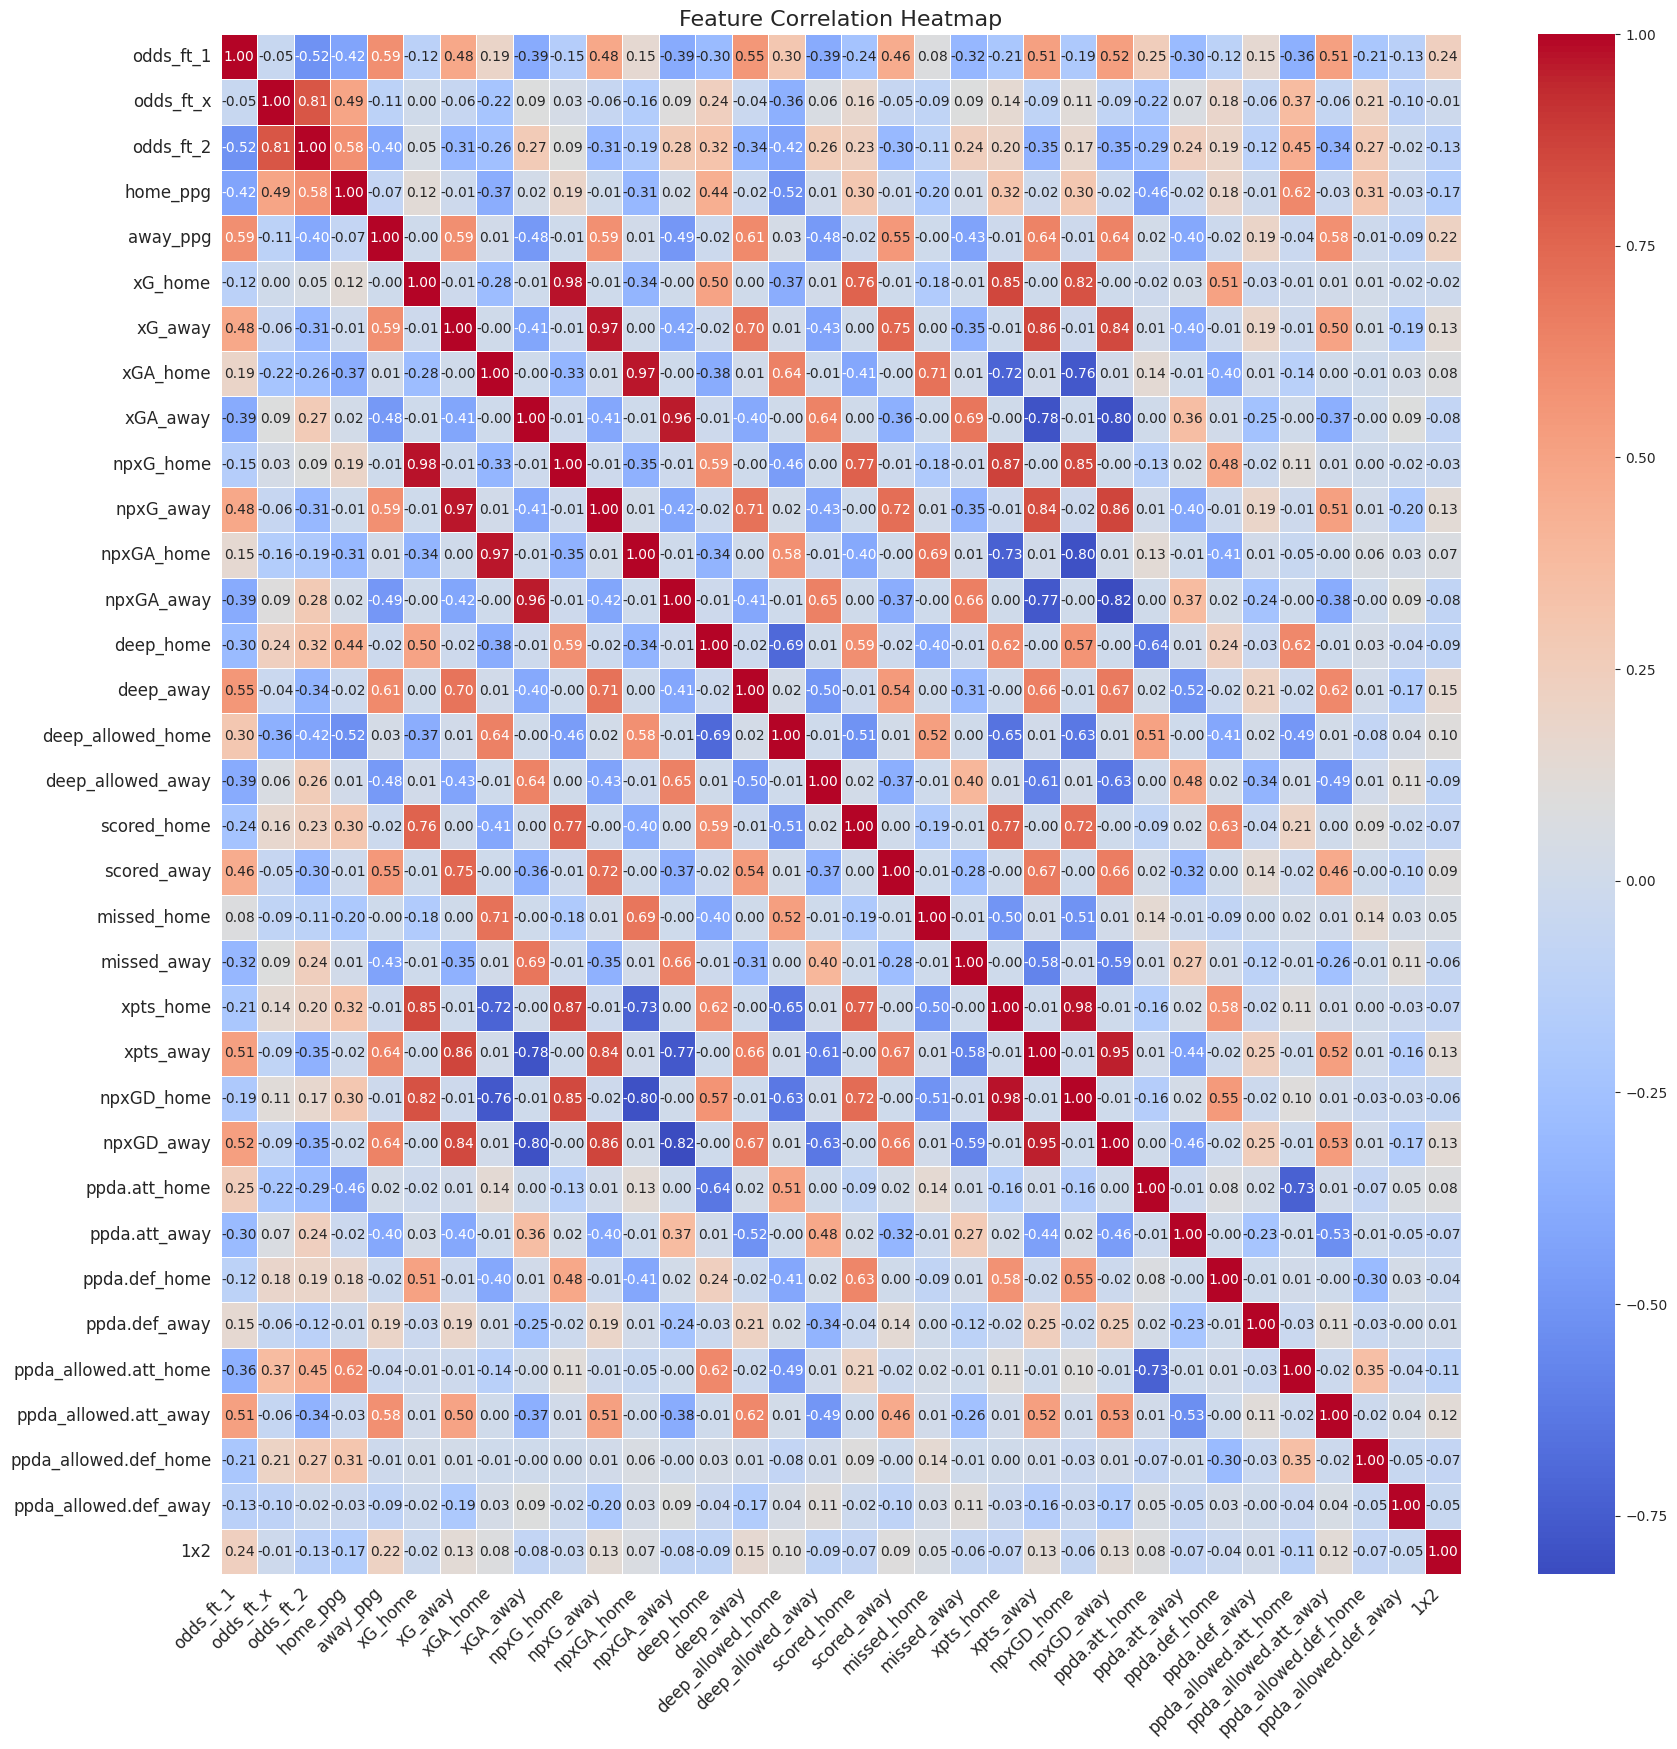

In [26]:
# Visualize the filtered correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.show()

### Correlation Insights

### Strong Negative Correlations:

- There is a strong negative correlation (-0.52) between "odds_ft_1" (home team winning odds) and "odds_ft_2" (away team winning odds), which is expected as these are opposing outcomes.
- "odds_ft_1" has a negative correlation with some defensive metrics like "xGA_home" (expected goals against for home team) and "xGA_away" (expected goals against for away team).

### Strong Positive Correlations:

- There is a strong positive correlation (0.77) between "odds_ft_x" (draw odds) and "odds_ft_2," indicating that when the odds for a draw increase, the odds for the away team winning also tend to increase.
- "home_ppg" (home team's average points per game) and "away_ppg" (away team's average points per game) have a positive correlation of 0.60, suggesting a correlation between the home and away teams' points per game.

### Other Interesting Correlations:

- "xG_home" (expected goals for home team) and "xG_away" (expected goals for away team) have a strong positive correlation (0.98), indicating consistency in the expected goals for both home and away teams.
- "scored_home" (actual goals scored by home team) and "scored_away" (actual goals scored by away team) have a strong positive correlation (0.86), showing that the number of goals scored by home and away teams is strongly related.

### Correlation with Match Outcomes:

- The variables related to odds ("odds_ft_1," "odds_ft_x," "odds_ft_2") have correlations with various metrics, suggesting a relationship between bookmakers' odds and team performance.



In [27]:

# Set correlation threshold
correlation_threshold = 0.8  

# Create a copy of the DataFrame
df_no_collinearity = cleaned_data.copy()

# Get the upper triangle of the correlation matrix
upper_triangle = df_no_collinearity.corr().abs().where(np.triu(np.ones(df_no_collinearity.corr().abs().shape), k=1).astype(bool))

# Find and drop columns with correlation above the threshold
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]

df_no_collinearity.drop(to_drop, axis=1, inplace=True)


In [28]:
# check shape of cleaned data
cleaned_data.shape

(3026, 34)

In [29]:
# check shape of no_collinearity dataframe
df_no_collinearity.shape

(3026, 25)

In [30]:
df_no_collinearity.columns

Index(['odds_ft_1', 'odds_ft_x', 'home_ppg', 'away_ppg', 'xG_home', 'xG_away',
       'xGA_home', 'xGA_away', 'deep_home', 'deep_away', 'deep_allowed_home',
       'deep_allowed_away', 'scored_home', 'scored_away', 'missed_home',
       'missed_away', 'ppda.att_home', 'ppda.att_away', 'ppda.def_home',
       'ppda.def_away', 'ppda_allowed.att_home', 'ppda_allowed.att_away',
       'ppda_allowed.def_home', 'ppda_allowed.def_away', '1x2'],
      dtype='object')

In [31]:
[column for column in cleaned_data.columns if column not in df_no_collinearity.columns]

['odds_ft_2',
 'npxG_home',
 'npxG_away',
 'npxGA_home',
 'npxGA_away',
 'xpts_home',
 'xpts_away',
 'npxGD_home',
 'npxGD_away']

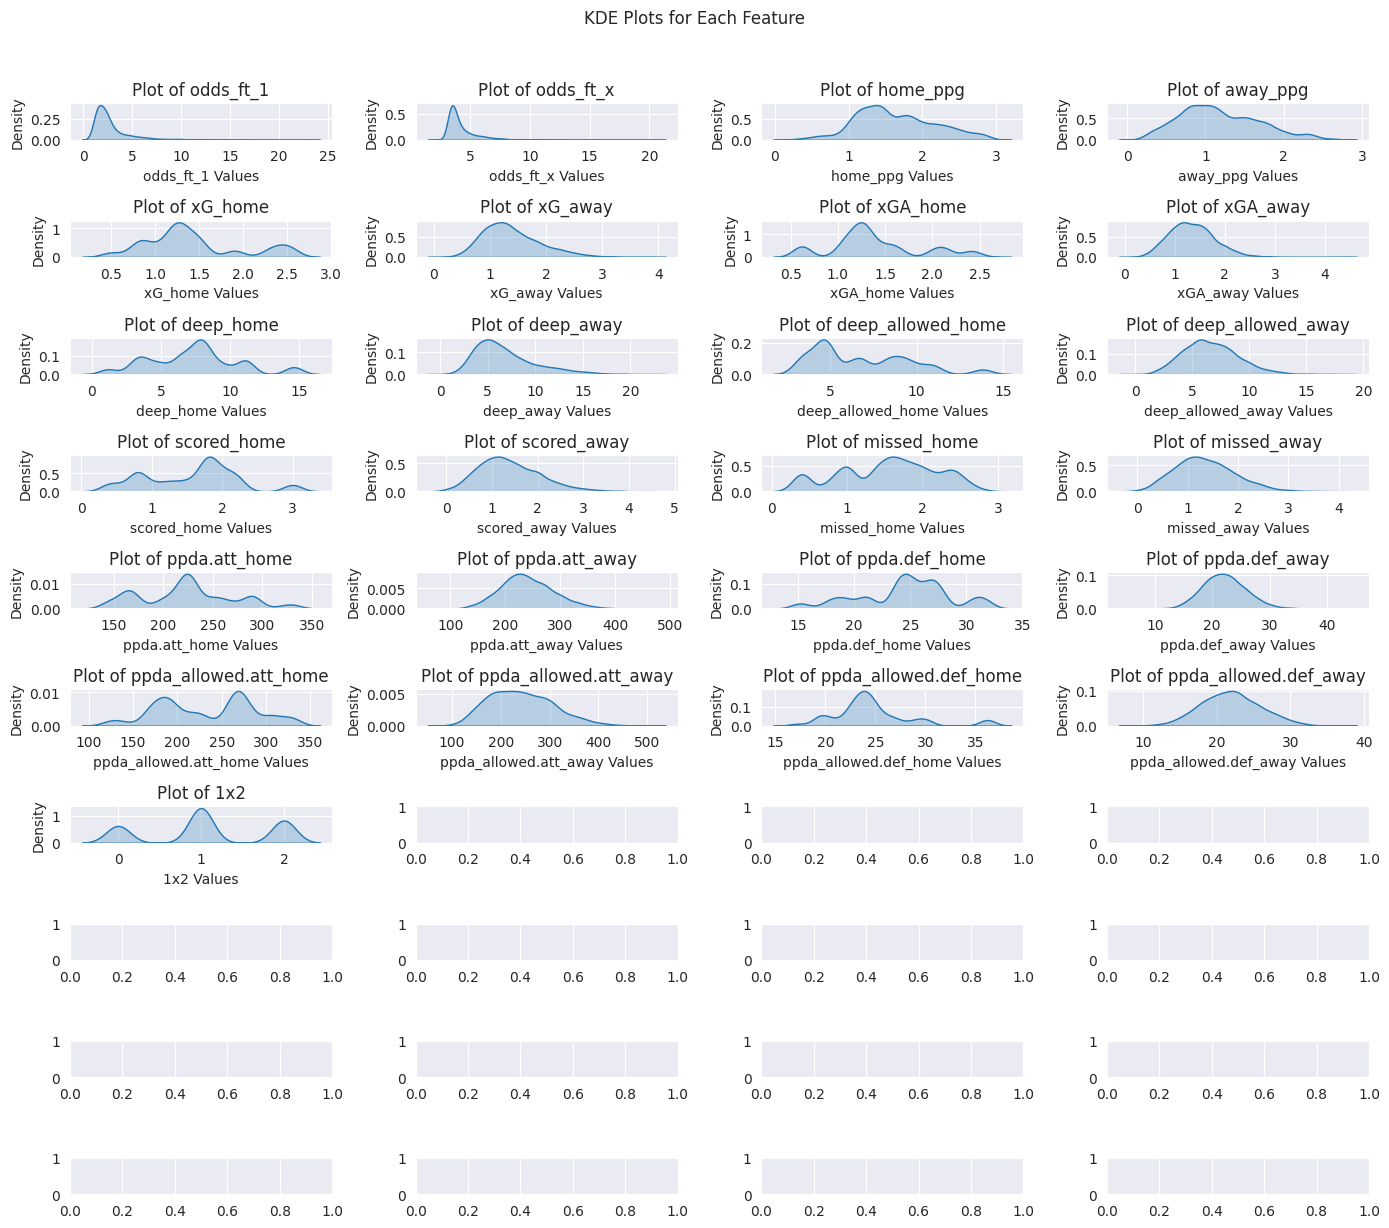

In [32]:
features = df_no_collinearity.columns.tolist()

# Set up subplots
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(14, 12))
fig.suptitle('KDE Plots for Each Feature', y=1.02)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through features and create KDE plots or count plots
for i, feature in enumerate(features):
    if df_no_collinearity[feature].dtype == 'O':
        sns.countplot(x=feature, data=df_no_collinearity, ax=axes[i])
    else:
        sns.kdeplot(x=df_no_collinearity[feature], fill=True, ax=axes[i])

    axes[i].set_title(f'Plot of {feature}')
    axes[i].set_xlabel(f'{feature} Values')
    axes[i].set_ylabel('Density' if df_no_collinearity[feature].dtype != 'O' else 'Count')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [33]:
# Separate features (X) and target variable (y)
X = df_no_collinearity.drop(columns=['1x2'])  # Features
y = df_no_collinearity['1x2']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [34]:
# scale the features using standard scaler
standard_scaler = StandardScaler()

# Fit and transform the training set to standardize its features
X_train_std_encoded = standard_scaler.fit_transform(X_train)

# Transform the testing set using the same scaler to maintain consistency
X_test_std_encoded = standard_scaler.transform(X_test)



In [35]:
# scale the features using minmax scaler
min_max_scaler = MinMaxScaler()

# Fit and transform the training set to standardize its features
X_train_min_max_encoded = min_max_scaler.fit_transform(X_train)

# Transform the testing set using the same scaler to maintain consistency
X_test_min_max_encoded = min_max_scaler.transform(X_test)



In [36]:
# Convert y to a NumPy array and reshape it to a 2D array
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the y_train
y_train_encoded = encoder.fit_transform(y_train)

# Fit and transform the y_test
y_test_encoded = encoder.transform(y_test)

In [37]:
# After fitting the encoder, you can access the categories
categories = encoder.categories_

# Assuming you have only one column in your target variable
encoded_mapping = {index: category for index, category in enumerate(categories[0])}

# Print the mapping
print(encoded_mapping)

{0: 0, 1: 1, 2: 2}


In [38]:
# create directory to host all plots
os.makedirs('/kaggle/working/plots', exist_ok=True)

# define plots  directory 

base_plots_dir = '/kaggle/working/plots/'

In [39]:
# define base path for directory to contain plots
base_plot_path = '/plots/'

# Create the plots directory if it doesn't exist
os.makedirs(base_plot_path, exist_ok=True)

In [40]:
def plot_confusion_mat(conf_matrix, cm_title):
    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Class 0', 'Class 1', 'Class 2'],
                yticklabels=['Class 0', 'Class 1', 'Class 2'])
    plt.title(cm_title)
    plt.xlabel('Predicted')
    plt.ylabel('True')

    
    # Save the plot to the specified path
    plot_path = os.path.join(base_plots_dir, cm_title)
    plt.savefig(plot_path)
    plt.show()

In [41]:
def plot_training_history(history, lr=None, model_name=None):
    # Plot training and validation loss
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    if lr is not None and 'lr' in history.params:
        # Plot learning rate
        plt.figure(figsize=(6, 6))
        plt.plot(history.history['lr'], label='Learning Rate', color='red')
        plt.title('Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('LR')
        plt.legend()
    
    # Save the plot to the specified path
    plot_path = os.path.join(base_plots_dir, f'{model_name}_th')
    plt.savefig(plot_path)
    plt.tight_layout()
    plt.show()




In [42]:
def plot_evaluation_metrics(y_true, y_pred, model_name):
    
    # Calculate precision, recall, and f1 score
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    
    # Create lists for labels and corresponding scores
    labels = ['Precision', 'Recall', 'F1 Score', 'Accuracy']
    scores = [precision, recall, f1, accuracy]

    # Set a color palette for the bars
    colors = ['#7f8c8d', '#95a5a6', '#bdc3c7', '#3498db']  # Added a color for accuracy (blue)

    # Plotting the bar chart
    fig, ax = plt.subplots()
    bars = ax.bar(labels, scores, color=colors)

    # Adding data values above the bars with adjusted positioning
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', color='black', fontweight='bold')

    # Adding title and labels
    plt.title(f'{model_name} Model Evaluation Metrics', fontsize=16, fontweight='bold', y=1.05)  # Adjusted y position for title
    plt.xlabel('Metrics', fontsize=12, fontweight='bold')
    plt.ylabel('Score', fontsize=12, fontweight='bold')

    # Adjusting y-axis limits and grid
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Showing x-axis ticks with labels
    plt.xticks(labels)
    
    # Save the plot to the specified path
    plot_path = os.path.join(base_plots_dir, f'{model_name}_metrics')
    plt.savefig(plot_path)
    
    # Show the plot
    plt.show()


In [43]:
def eval_model(model, model_name=None, X_test=X_test_min_max_encoded, y_test=y_test_encoded, 
               grid_search=None,sgd=False,  history=None, lr=None):
    if sgd:
        if grid_search:
            # Get the best parameters from the grid search
            best_params = grid_search.best_params_
            print(f"Best Parameters: {best_params}")

            # Get the best model from the grid search
            best_model = grid_search.best_estimator_

            # Make predictions on the test data
            y_pred_sgd = best_model.predict(X_test)

            # Convert y_pred_sgd to a NumPy array and reshape it to a 2D array

            y_pred_sgd = np.array(y_pred_sgd).reshape(-1, 1)
            y_pred_sgd_encoded = encoder.transform(y_pred_sgd)

            # Evaluate the performance of the  classifier
            plot_evaluation_metrics(y_test, y_pred_sgd_encoded, model_name)
        
        else:
            # Make predictions on the test data
            y_pred_sgd = model.predict(X_test)

            # Convert y_pred_sgd to a NumPy array and reshape it to a 2D array

            y_pred_sgd = np.array(y_pred_sgd).reshape(-1, 1)
            y_pred_sgd_encoded = encoder.transform(y_pred_sgd)

            # Evaluate the performance of the  classifier
            plot_evaluation_metrics(y_test, y_pred_sgd_encoded, model_name)
    
    elif history:
        # Evaluate the model on the test set
        accuracy = model.evaluate(X_test, y_test)[1]
        print(f"Test Accuracy: {accuracy:.2f}")
        # Evaluate the model on the test set
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test, axis=1)
        
        # Create and plot  confusion matrix
        conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
        
        cm_title = f"CM {model_name}"
        
        plot_confusion_mat(conf_matrix, cm_title)
        
        # plot training loss, training acc and val acc
        plot_training_history(history=history, model_name=model_name)
        
        # Evaluate the performance of the  classifier
        plot_evaluation_metrics(y_true_classes, y_pred_classes, model_name)
        
        
        
    elif grid_search:
        # Get the best parameters from the grid search
        best_params = grid_search.best_params_
        print(f"Best Parameters: {best_params}")

        # Get the best model from the grid search
        best_model = grid_search.best_estimator_

        # Make predictions on the test set using the best model
        y_pred = best_model.predict(X_test)
        
        # Evaluate the performance of the tuned  classifier
        plot_evaluation_metrics(y_test, y_pred, model_name)
    else:
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        # Evaluate the performance of the  classifier
        plot_evaluation_metrics(y_test, y_pred, model_name)

# Modelling 

### Base model - Decision Tree Classifier

In [44]:
# initialize  a decision classifier model
dt_base_clf = DecisionTreeClassifier(random_state=0)

# fit basic model
dt_base_clf.fit(X_train_min_max_encoded, y_train_encoded)


DecisionTreeClassifier(random_state=0)

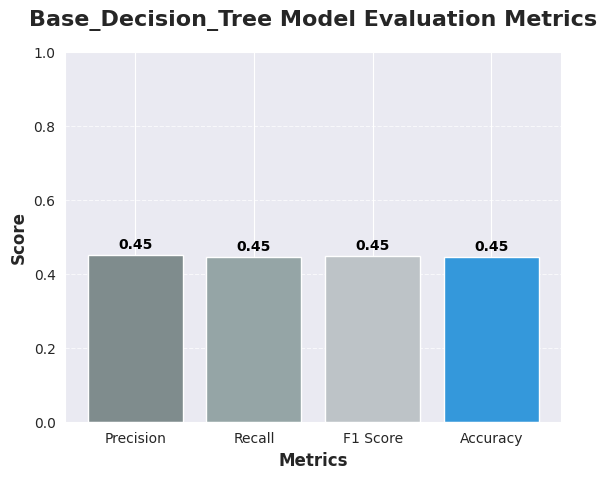

In [45]:
eval_model(model=dt_base_clf, model_name='Base_Decision_Tree',  X_test=X_test_min_max_encoded, 
           y_test=y_test_encoded)

### Optimizing Decision Tree Classifier

In [46]:
# Define the parameter grid to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Decision Tree Classifier instance
dt_clf_tuned = DecisionTreeClassifier(random_state=0)

# Create GridSearchCV object
grid_search = GridSearchCV(dt_clf_tuned, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_min_max_encoded, y_train_encoded)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_



Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


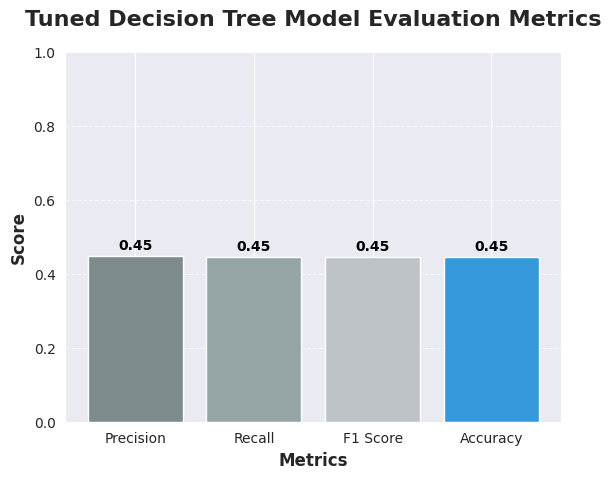

In [47]:
eval_model(model=dt_clf_tuned, model_name='Tuned Decision Tree',  X_test=X_test_min_max_encoded, 
           y_test=y_test_encoded, grid_search=grid_search)

### Base model - Random Forest Classifier

In [48]:
# initialize base random forest classifier
rf_base_clf = RandomForestClassifier(random_state=0)

# fit rf classifier 
rf_base_clf.fit(X_train_min_max_encoded, y_train_encoded)

RandomForestClassifier(random_state=0)

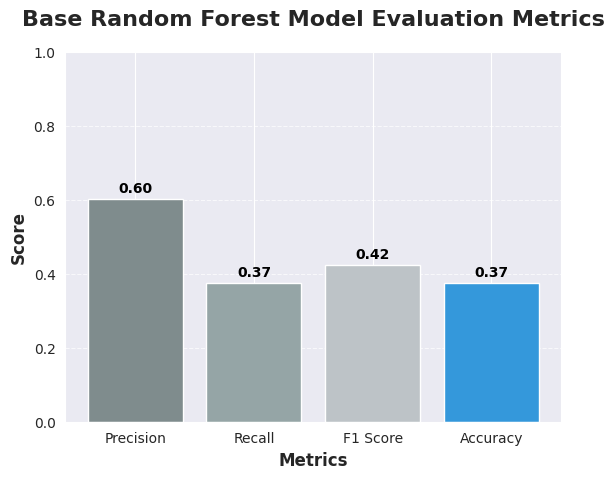

In [49]:
eval_model(model=rf_base_clf, model_name='Base Random Forest',  X_test=X_test_min_max_encoded, 
           y_test=y_test_encoded)

### Optimizing RF Classifier

In [50]:
# Initialize base random forest classifier
rf_opt_clf = RandomForestClassifier(random_state=0)


# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]  # Update this line
}


# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_opt_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_min_max_encoded, y_train_encoded)



GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

Best Parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


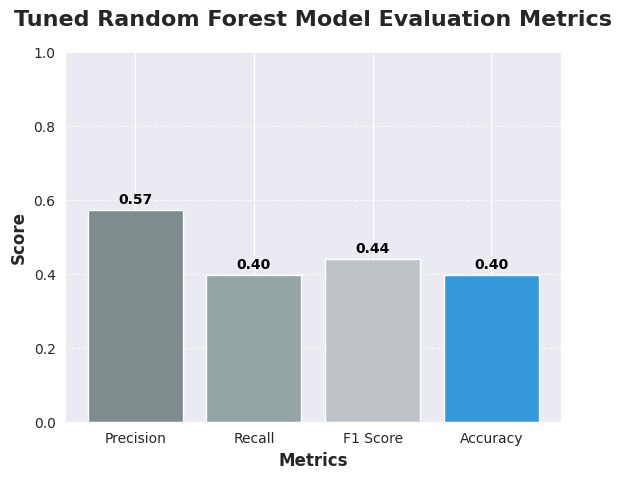

In [51]:
eval_model(model=rf_opt_clf, model_name='Tuned Random Forest',  X_test=X_test_min_max_encoded, 
           y_test=y_test_encoded, grid_search=grid_search)

### Base model - SGD Classifier

In [52]:
# flatten y_train  as SGD expects  1-d data

flattened_y_train = y_train.flatten()


In [53]:
# Initialize SGD classifier
sgd_clf = SGDClassifier(random_state=0)

# Fit the classifier to the training data
sgd_clf.fit(X_train_std_encoded, flattened_y_train)


SGDClassifier(random_state=0)

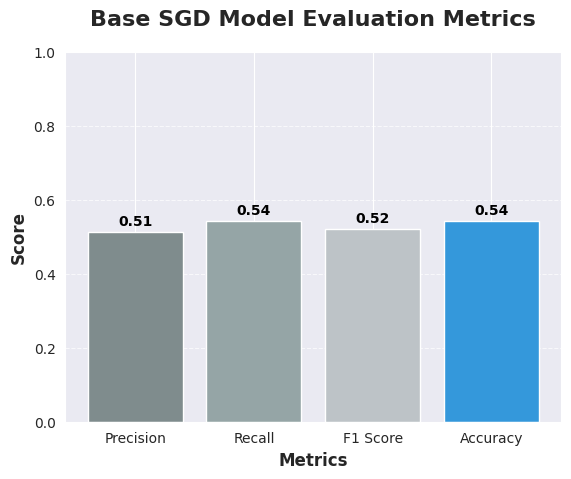

In [54]:
eval_model(model=sgd_clf, model_name='Base SGD',  X_test=X_test_std_encoded, 
           y_test=y_test_encoded, sgd=True)

### Optimizing SGD Classifier

In [55]:
# Suppress SciPy warning
warnings.filterwarnings("ignore", message="A NumPy version >=1.16.5 and <1.23.0 is required")

# Suppress Sklearn warning
warnings.filterwarnings("ignore", category=FutureWarning)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'max_iter': [1000, 2000, 3000],
    'tol': [1e-3, 1e-4, 1e-5],
}

# Initialize SGD classifier
sgd_clf = SGDClassifier(random_state=0)

# Create GridSearchCV object
grid_search = GridSearchCV(sgd_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_std_encoded, flattened_y_train)



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic

GridSearchCV(cv=5, estimator=SGDClassifier(random_state=0), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'loss': ['hinge', 'log_loss', 'modified_huber',
                                  'squared_hinge'],
                         'max_iter': [1000, 2000, 3000],
                         'penalty': ['l2', 'l1', 'elasticnet'],
                         'tol': [0.001, 0.0001, 1e-05]},
             scoring='accuracy')

Best Parameters: {'alpha': 0.01, 'loss': 'log_loss', 'max_iter': 1000, 'penalty': 'l1', 'tol': 0.0001}


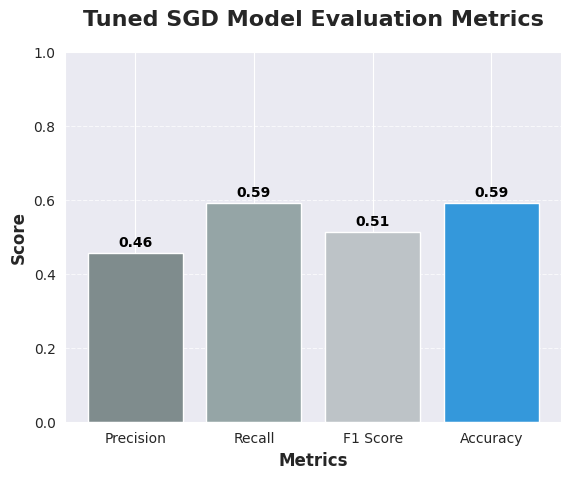

In [56]:
eval_model(model=sgd_clf, model_name='Tuned SGD',  X_test=X_test_std_encoded, 
           y_test=y_test_encoded, sgd=True, grid_search=grid_search)

### Base xGBoost Model

In [57]:
# Initialize XGBoost classifier
xgb_base_clf = xgb.XGBClassifier(random_state=0)

# Fit the model on the training data
xgb_base_clf.fit(X_train_min_max_encoded, y_train_encoded)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

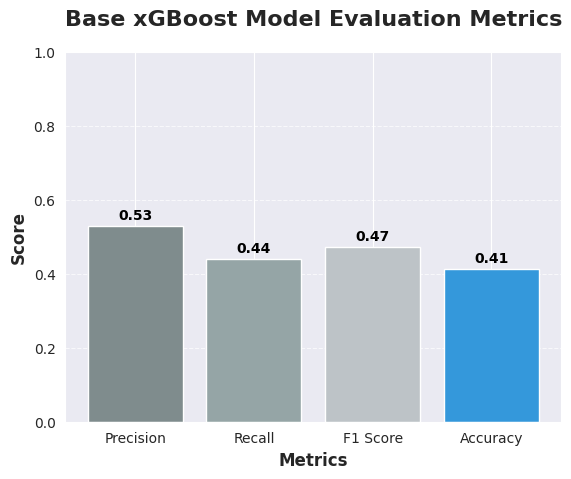

In [58]:
# Evaluate the performance of the XGBoost classifier
eval_model(model=xgb_base_clf, model_name='Base xGBoost',  X_test=X_test_min_max_encoded, 
           y_test=y_test_encoded)

### Optimizing xGBoost Model

In [59]:
# Define the parameter grid for XGBoost
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'n_estimators': [50, 100, 200]
}

# Initialize XGBoost classifier
xgb_tuned_clf = xgb.XGBClassifier(random_state=0)

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(estimator=xgb_tuned_clf, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform Grid Search on the training data
grid_search.fit(X_train_min_max_encoded, y_train_encoded)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='accuracy')

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.9}


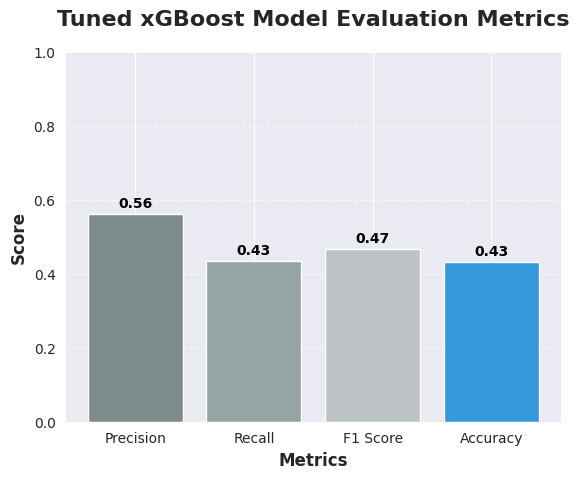

In [60]:
# Evaluate the performance of the XGBoost classifier
eval_model(model=xgb_tuned_clf, model_name='Tuned xGBoost',  X_test=X_test_min_max_encoded, 
           y_test=y_test_encoded, grid_search=grid_search)

# Base LSTM model

In [61]:
# Define ModelCheckpoint callback to save the best base model
checkpoint_filepath = '/kaggle/working/models/best_base_lstm_model'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, 
                                   monitor='val_accuracy', mode='max', verbose=1)


In [62]:
# LSTM model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(X_train_min_max_encoded.shape[1], 1)))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))
# 3 classes, so output layer has 3 units and 'softmax' activation

# Compile the model with 'categorical_crossentropy' loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_min_max_encoded, y_train_encoded, epochs=100, batch_size=32, 
                    validation_split=0.2, callbacks=[model_checkpoint])



Epoch 1/100
60/61 [============================>.] - ETA: 0s - loss: 1.0641 - accuracy: 0.4672
Epoch 1: val_accuracy improved from -inf to 0.48347, saving model to /kaggle/working/models/best_base_lstm_model
61/61 [==============================] - 6s 71ms/step - loss: 1.0639 - accuracy: 0.4675 - val_loss: 1.0425 - val_accuracy: 0.4835
Epoch 2/100
59/61 [============================>.] - ETA: 0s - loss: 1.0580 - accuracy: 0.4688
Epoch 2: val_accuracy did not improve from 0.48347
61/61 [==============================] - 2s 27ms/step - loss: 1.0586 - accuracy: 0.4675 - val_loss: 1.0434 - val_accuracy: 0.4835
Epoch 3/100
59/61 [============================>.] - ETA: 0s - loss: 1.0566 - accuracy: 0.4666
Epoch 3: val_accuracy did not improve from 0.48347
61/61 [==============================] - 2s 26ms/step - loss: 1.0565 - accuracy: 0.4675 - val_loss: 1.0397 - val_accuracy: 0.4835
Epoch 4/100
61/61 [==============================] - ETA: 0s - loss: 1.0560 - accuracy: 0.4675
Epoch 4: val_ac

19/19 [==============================] - 0s 10ms/step - loss: 0.9247 - accuracy: 0.5693
Test Accuracy: 0.57
19/19 [==============================] - 0s 11ms/step


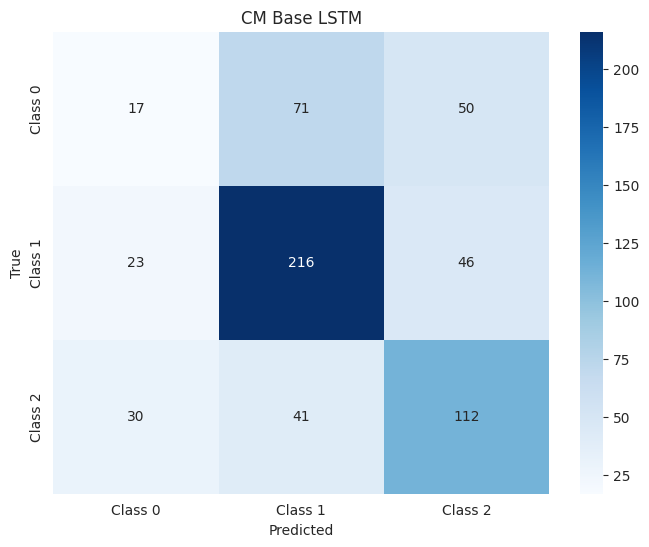

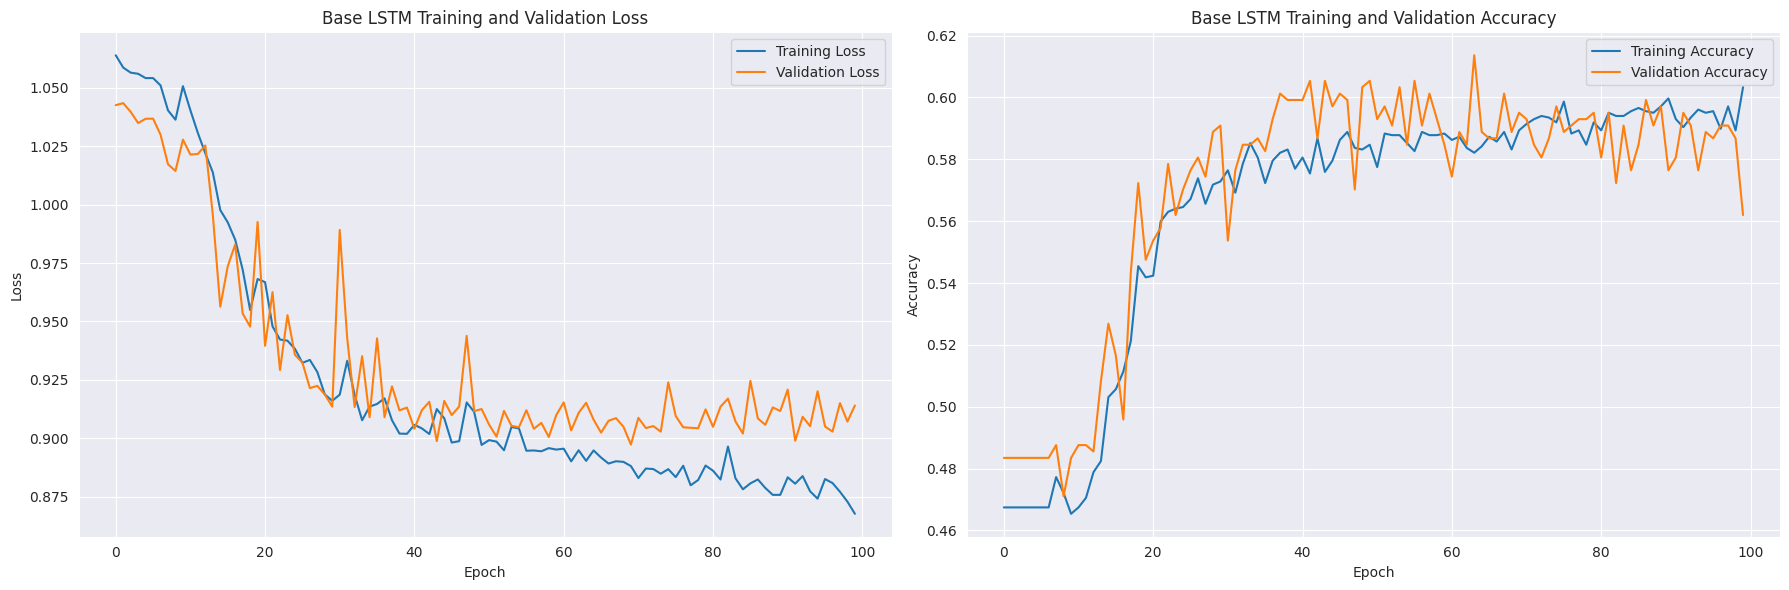

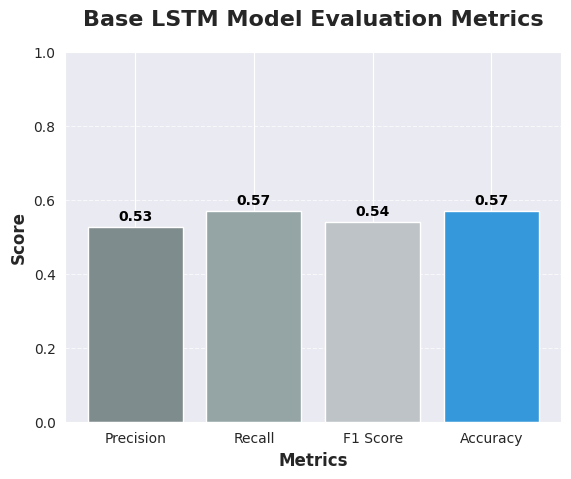

In [63]:
# Evaluate the performance of the base lstm classifier
eval_model(model=model, model_name='Base LSTM',  X_test=X_test_min_max_encoded, 
           y_test=y_test_encoded, history=history)

### Testing Different LSTM Architecture

In [64]:
# Define ModelCheckpoint callback to save the best base model
checkpoint_filepath = '/kaggle/working/models/best_tuned_lstm_model'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, 
                                   monitor='val_accuracy', mode='max', verbose=1)


In [65]:
# LSTM model with dropout for hyperparameter tuning
model = Sequential()

# Add an LSTM layer with 64 units and ReLU activation
model.add(LSTM(64, activation='relu', input_shape=(X_train_min_max_encoded.shape[1], 1)))

# Add dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Add a Dense layer with 64 units and ReLU activation
model.add(Dense(64, activation='relu'))

# Add another dropout layer
model.add(Dropout(0.5))

# Output layer with 3 units (3 classes) and softmax activation
model.add(Dense(3, activation='softmax'))

# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with 100 epochs, batch size of 32, and validation split of 20%
history = model.fit(X_train_min_max_encoded, y_train_encoded, epochs=100, batch_size=32, 
                    validation_split=0.2, callbacks=[model_checkpoint])


Epoch 1/100
61/61 [==============================] - ETA: 0s - loss: 1.0697 - accuracy: 0.4571
Epoch 1: val_accuracy improved from -inf to 0.48347, saving model to /kaggle/working/models/best_tuned_lstm_model
61/61 [==============================] - 5s 53ms/step - loss: 1.0697 - accuracy: 0.4571 - val_loss: 1.0384 - val_accuracy: 0.4835
Epoch 2/100
57/61 [===========================>..] - ETA: 0s - loss: 1.0617 - accuracy: 0.4660
Epoch 2: val_accuracy did not improve from 0.48347
61/61 [==============================] - 1s 14ms/step - loss: 1.0616 - accuracy: 0.4669 - val_loss: 1.0393 - val_accuracy: 0.4835
Epoch 3/100
59/61 [============================>.] - ETA: 0s - loss: 1.0606 - accuracy: 0.4672
Epoch 3: val_accuracy did not improve from 0.48347
61/61 [==============================] - 1s 14ms/step - loss: 1.0601 - accuracy: 0.4669 - val_loss: 1.0403 - val_accuracy: 0.4835
Epoch 4/100
59/61 [============================>.] - ETA: 0s - loss: 1.0546 - accuracy: 0.4693
Epoch 4: val_a

19/19 [==============================] - 0s 5ms/step - loss: 0.9136 - accuracy: 0.5842
Test Accuracy: 0.58
19/19 [==============================] - 0s 5ms/step


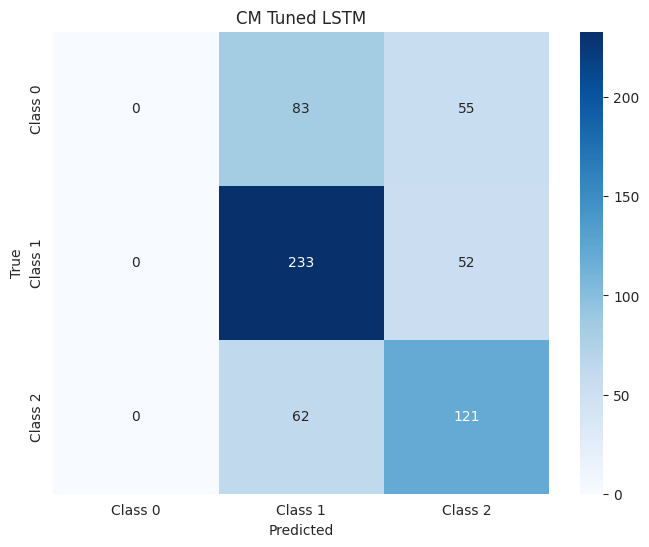

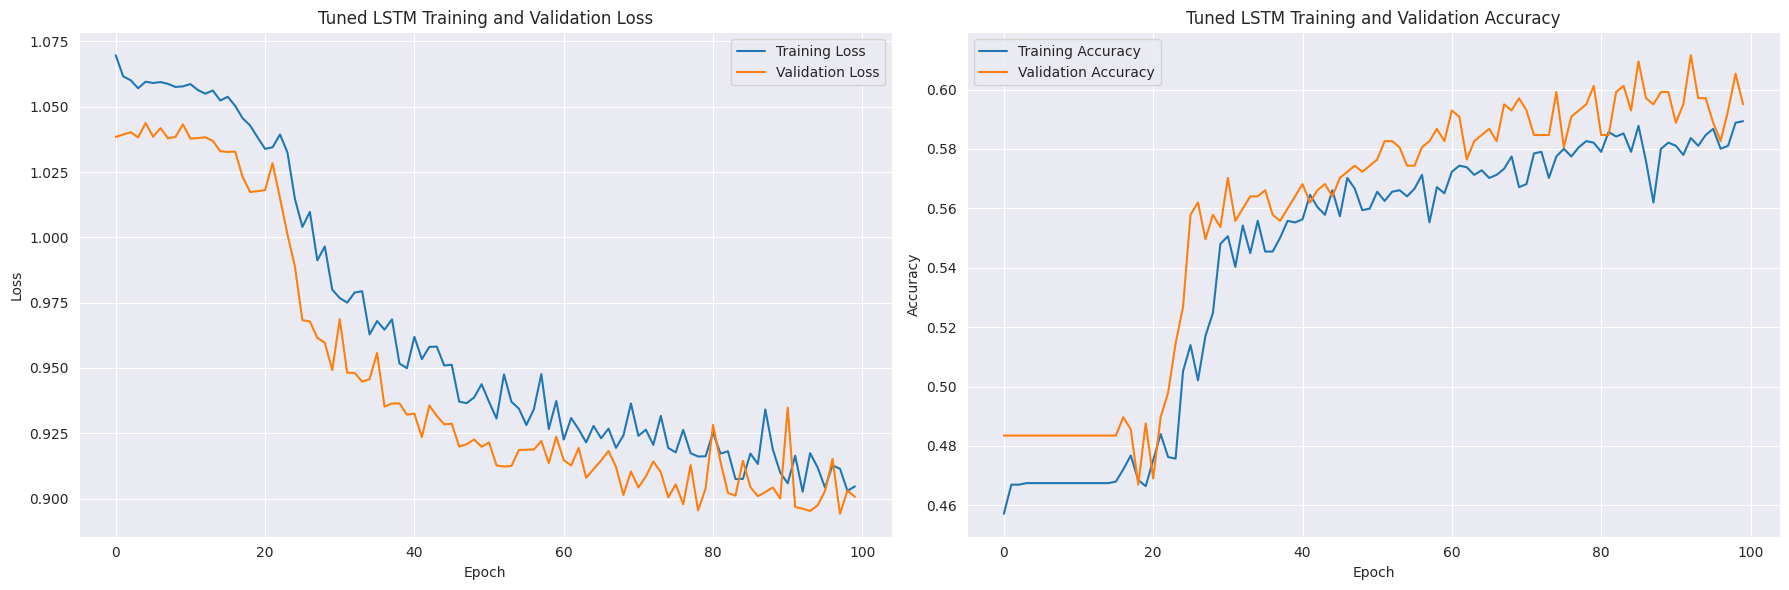

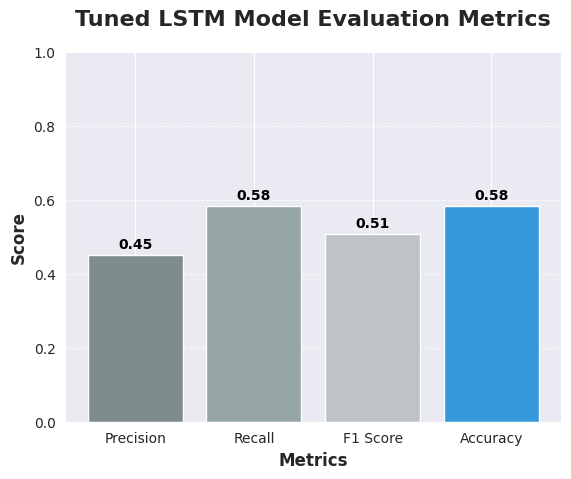

In [66]:
# Evaluate the performance of the base lstm classifier
eval_model(model=model, model_name='Tuned LSTM',  X_test=X_test_min_max_encoded, 
           y_test=y_test_encoded, history=history)

The model appears to mostly missing draws, it suggests that there might be a class imbalance issue. To address this issue, we will take try two approaches:
- SMOTE
- Class weighting

In [67]:
# Identify unique classes as a list
unique_classes = [0, 1, 2]

# Calculate class weights using the list of unique classes
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train.flatten().tolist())

# Create a dictionary of class weights for model training
class_weight_dict = dict(enumerate(class_weights))


### Base LTSM Model with Class Balancing

In [68]:
# Define ModelCheckpoint callback to save the best base model
checkpoint_filepath = '/kaggle/working/models/best_base_class_bal_lstm_model'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)


In [69]:
# LSTM model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(X_train_min_max_encoded.shape[1], 1)))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))
# 3 classes, so output layer has 3 units and 'softmax' activation

# Compile the model with 'categorical_crossentropy' loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_min_max_encoded, y_train_encoded,class_weight=class_weight_dict,  epochs=100, batch_size=32, 
                    validation_split=0.2, callbacks=[model_checkpoint])



Epoch 1/100
59/61 [============================>.] - ETA: 0s - loss: 1.1021 - accuracy: 0.2436
Epoch 1: val_accuracy improved from -inf to 0.48554, saving model to /kaggle/working/models/best_base_class_bal_lstm_model
61/61 [==============================] - 6s 62ms/step - loss: 1.1037 - accuracy: 0.2469 - val_loss: 1.0955 - val_accuracy: 0.4855
Epoch 2/100
60/61 [============================>.] - ETA: 0s - loss: 1.1037 - accuracy: 0.4182
Epoch 2: val_accuracy did not improve from 0.48554
61/61 [==============================] - 2s 26ms/step - loss: 1.1034 - accuracy: 0.4163 - val_loss: 1.1029 - val_accuracy: 0.1942
Epoch 3/100
61/61 [==============================] - ETA: 0s - loss: 1.1027 - accuracy: 0.2660
Epoch 3: val_accuracy did not improve from 0.48554
61/61 [==============================] - 2s 27ms/step - loss: 1.1027 - accuracy: 0.2660 - val_loss: 1.1014 - val_accuracy: 0.1942
Epoch 4/100
59/61 [============================>.] - ETA: 0s - loss: 1.1019 - accuracy: 0.2378
Epoch

19/19 [==============================] - 0s 11ms/step - loss: 0.9900 - accuracy: 0.5017
Test Accuracy: 0.50
19/19 [==============================] - 0s 10ms/step


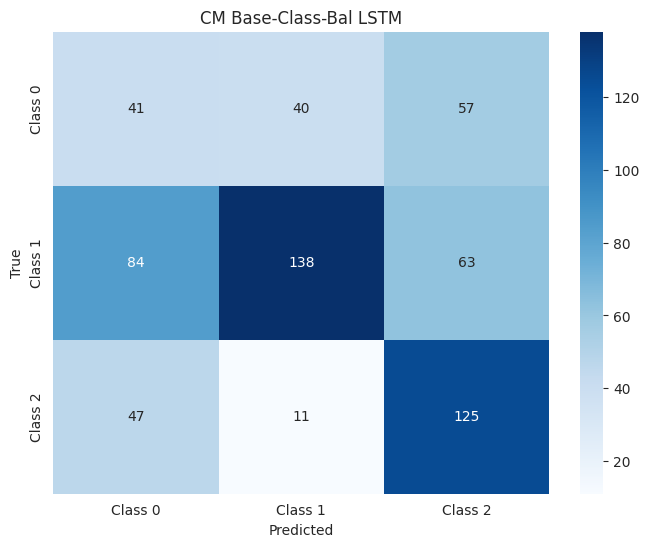

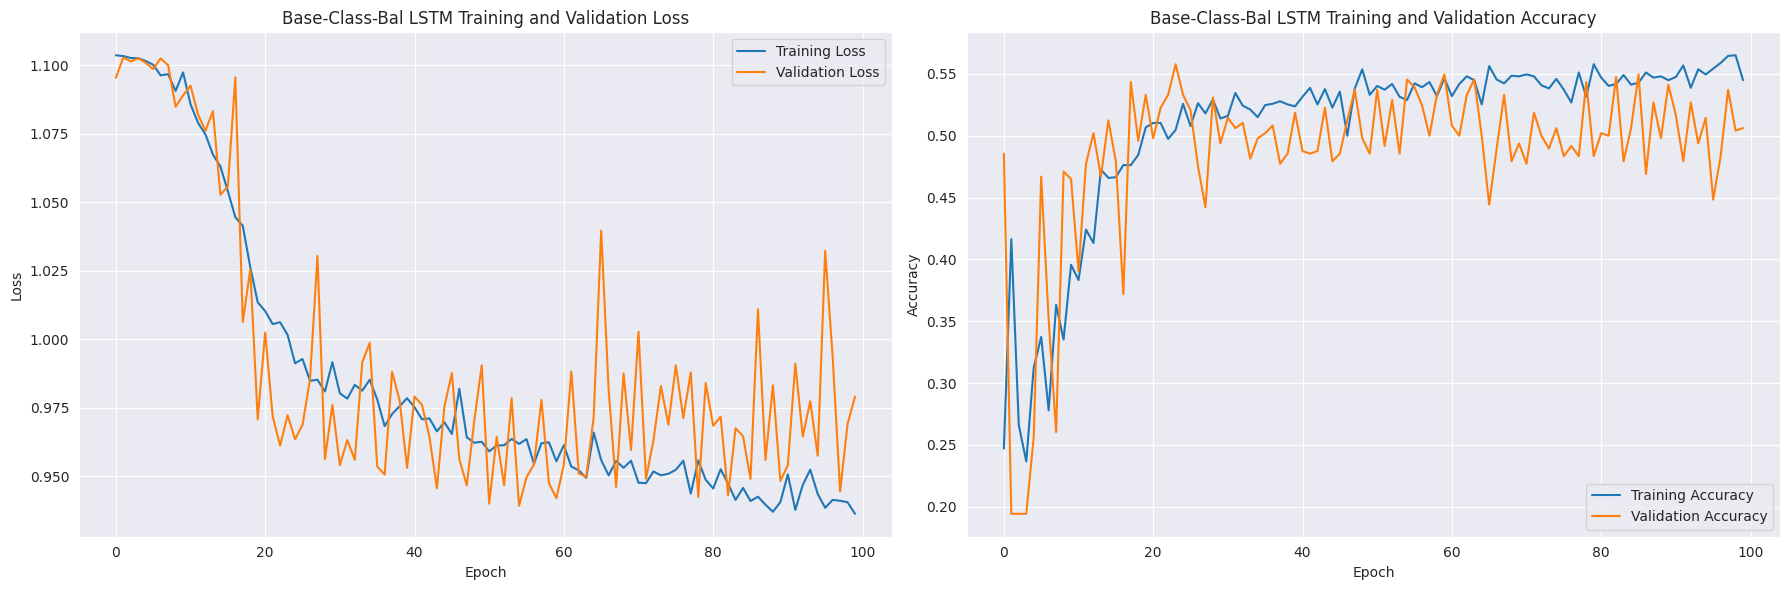

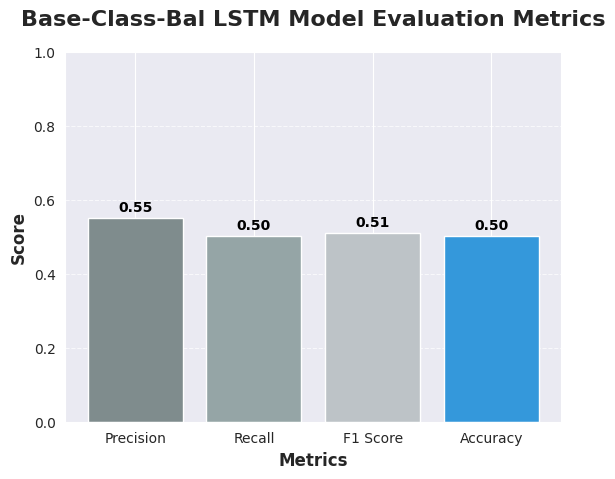

In [70]:
# Evaluate the performance of the base lstm classifier
eval_model(model=model, model_name='Base-Class-Bal LSTM',  X_test=X_test_min_max_encoded, 
           y_test=y_test_encoded, history=history)

### Tune LTSM Model with Class Balancing

In [71]:
# Define ModelCheckpoint callback to save the best base model
checkpoint_filepath = '/kaggle/working/models/best_tuned_class_bal_lstm_model'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, 
                                   monitor='val_accuracy', mode='max', verbose=1)


In [72]:
# LSTM model with dropout for hyperparameter tuning
model = Sequential()

# Add an LSTM layer with 64 units and ReLU activation
model.add(LSTM(64, activation='relu', input_shape=(X_train_min_max_encoded.shape[1], 1)))

# Add dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Add a Dense layer with 64 units and ReLU activation
model.add(Dense(64, activation='relu'))

# Add another dropout layer
model.add(Dropout(0.5))

# Output layer with 3 units (3 classes) and softmax activation
model.add(Dense(3, activation='softmax'))

# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with 100 epochs, batch size of 32, and validation split of 20%
history = model.fit(X_train_min_max_encoded, y_train_encoded,class_weight=class_weight_dict,  epochs=100, batch_size=32, 
                    validation_split=0.2, callbacks=[model_checkpoint])


Epoch 1/100
60/61 [============================>.] - ETA: 0s - loss: 1.1065 - accuracy: 0.3026
Epoch 1: val_accuracy improved from -inf to 0.19421, saving model to /kaggle/working/models/best_tuned_class_bal_lstm_model
61/61 [==============================] - 5s 54ms/step - loss: 1.1060 - accuracy: 0.3027 - val_loss: 1.1006 - val_accuracy: 0.1942
Epoch 2/100
60/61 [============================>.] - ETA: 0s - loss: 1.1037 - accuracy: 0.2984
Epoch 2: val_accuracy did not improve from 0.19421
61/61 [==============================] - 1s 14ms/step - loss: 1.1033 - accuracy: 0.2991 - val_loss: 1.1003 - val_accuracy: 0.1942
Epoch 3/100
61/61 [==============================] - ETA: 0s - loss: 1.1046 - accuracy: 0.2975
Epoch 3: val_accuracy did not improve from 0.19421
61/61 [==============================] - 1s 14ms/step - loss: 1.1046 - accuracy: 0.2975 - val_loss: 1.1038 - val_accuracy: 0.1942
Epoch 4/100
58/61 [===========================>..] - ETA: 0s - loss: 1.1036 - accuracy: 0.2856
Epoc

19/19 [==============================] - 0s 5ms/step - loss: 0.9657 - accuracy: 0.5413
Test Accuracy: 0.54
19/19 [==============================] - 0s 5ms/step


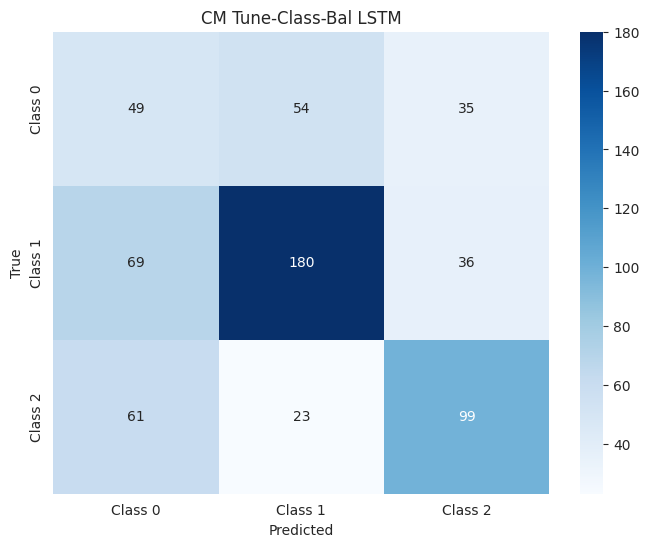

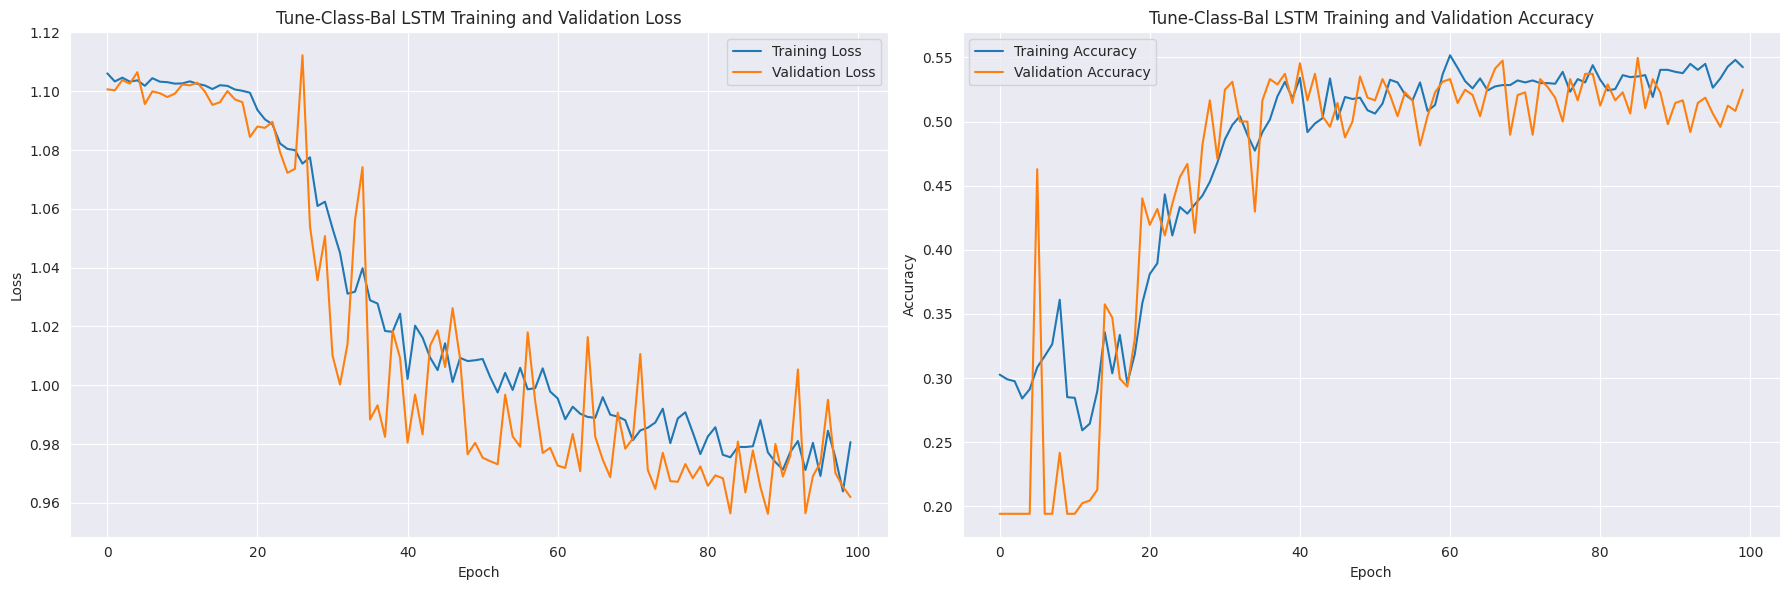

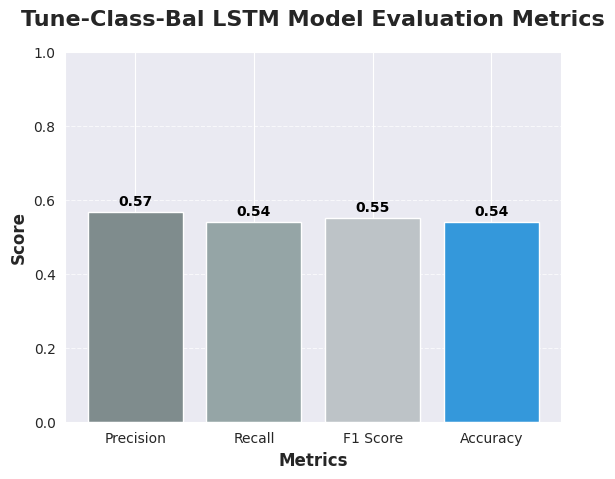

In [73]:
# Evaluate the performance of the base lstm classifier
eval_model(model=model, model_name='Tune-Class-Bal LSTM',  X_test=X_test_min_max_encoded, 
           y_test=y_test_encoded, history=history)

### LSTM with SMOTE

In [74]:
# Create an instance of the SMOTE class
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_min_max_encoded, y_train_encoded)

In [75]:
# Define ModelCheckpoint callback to save the best base smote model
checkpoint_filepath = '/kaggle/working/models/best_base_smote_lstm_model'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, 
                                   monitor='val_accuracy', mode='max', verbose=1)


In [76]:
# LSTM model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(X_train_min_max_encoded.shape[1], 1)))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))
# 3 classes, so output layer has 3 units and 'softmax' activation

# Compile the model with 'categorical_crossentropy' loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=32, 
                    validation_split=0.2, callbacks=[model_checkpoint])



Epoch 1/100
85/86 [============================>.] - ETA: 0s - loss: 1.0829 - accuracy: 0.4136
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to /kaggle/working/models/best_base_smote_lstm_model
86/86 [==============================] - 7s 61ms/step - loss: 1.0830 - accuracy: 0.4131 - val_loss: 1.2489 - val_accuracy: 0.0000e+00
Epoch 2/100
86/86 [==============================] - ETA: 0s - loss: 1.0792 - accuracy: 0.4168
Epoch 2: val_accuracy did not improve from 0.00000
86/86 [==============================] - 2s 27ms/step - loss: 1.0792 - accuracy: 0.4168 - val_loss: 1.2739 - val_accuracy: 0.0000e+00
Epoch 3/100
85/86 [============================>.] - ETA: 0s - loss: 1.0788 - accuracy: 0.4173
Epoch 3: val_accuracy did not improve from 0.00000
86/86 [==============================] - 2s 26ms/step - loss: 1.0794 - accuracy: 0.4168 - val_loss: 1.2735 - val_accuracy: 0.0000e+00
Epoch 4/100
85/86 [============================>.] - ETA: 0s - loss: 1.0772 - accuracy: 0.41

19/19 [==============================] - 0s 11ms/step - loss: 0.9924 - accuracy: 0.5132
Test Accuracy: 0.51
19/19 [==============================] - 0s 10ms/step


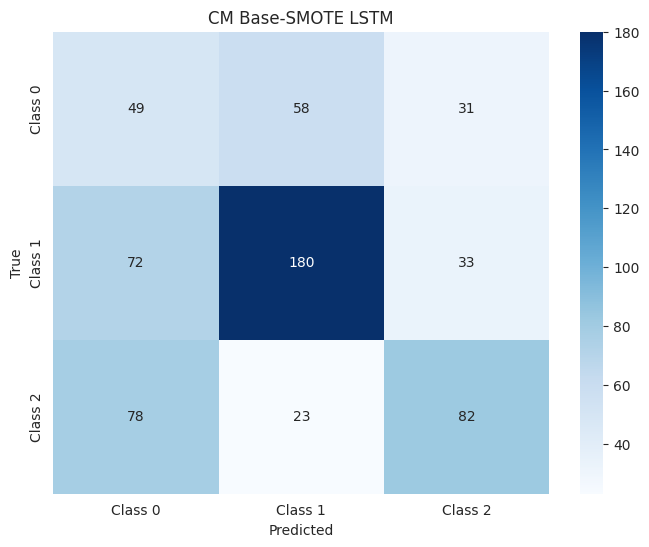

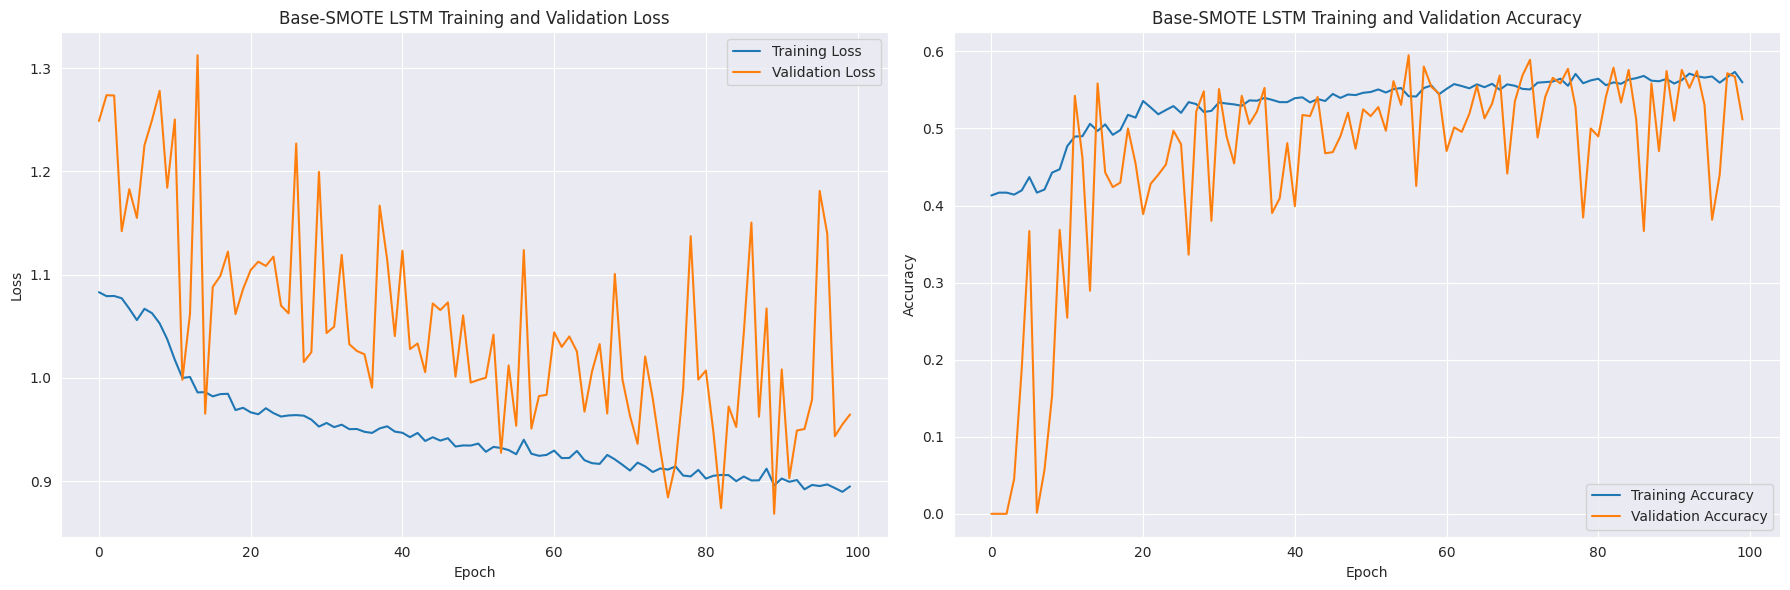

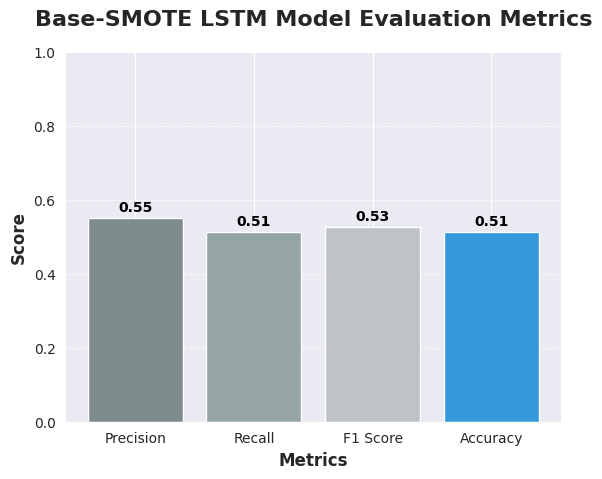

In [77]:
# Evaluate the performance of the base lstm classifier
eval_model(model=model, model_name='Base-SMOTE LSTM',  X_test=X_test_min_max_encoded, 
           y_test=y_test_encoded, history=history)

In [78]:
# Define ModelCheckpoint callback to save the best base model
smote_checkpoint_filepath = '/kaggle/working/models/smote_tuned_lstm_model'
model_checkpoint = ModelCheckpoint(filepath=smote_checkpoint_filepath, save_best_only=True, 
                                   monitor='val_accuracy', mode='max', verbose=1)


In [79]:
# LSTM model with dropout for hyperparameter tuning
model = Sequential()

# Add an LSTM layer with 64 units and ReLU activation
model.add(LSTM(64, activation='relu', input_shape=(X_train_min_max_encoded.shape[1], 1)))

# Add dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Add a Dense layer with 64 units and ReLU activation
model.add(Dense(64, activation='relu'))

# Add another dropout layer
model.add(Dropout(0.5))

# Output layer with 3 units (3 classes) and softmax activation
model.add(Dense(3, activation='softmax'))

# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with 100 epochs, batch size of 32, and validation split of 20%
history = model.fit(X_train_resampled, y_train_resampled,  epochs=100, batch_size=32, 
                    validation_split=0.2, callbacks=[model_checkpoint])


Epoch 1/100
85/86 [============================>.] - ETA: 0s - loss: 1.0886 - accuracy: 0.4040
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to /kaggle/working/models/smote_tuned_lstm_model
86/86 [==============================] - 5s 41ms/step - loss: 1.0884 - accuracy: 0.4047 - val_loss: 1.2501 - val_accuracy: 0.0000e+00
Epoch 2/100
86/86 [==============================] - ETA: 0s - loss: 1.0830 - accuracy: 0.4157
Epoch 2: val_accuracy did not improve from 0.00000
86/86 [==============================] - 1s 14ms/step - loss: 1.0830 - accuracy: 0.4157 - val_loss: 1.2401 - val_accuracy: 0.0000e+00
Epoch 3/100
82/86 [===========================>..] - ETA: 0s - loss: 1.0819 - accuracy: 0.4181
Epoch 3: val_accuracy did not improve from 0.00000
86/86 [==============================] - 1s 14ms/step - loss: 1.0820 - accuracy: 0.4168 - val_loss: 1.2525 - val_accuracy: 0.0000e+00
Epoch 4/100
86/86 [==============================] - ETA: 0s - loss: 1.0809 - accuracy: 0.4168
E

19/19 [==============================] - 0s 5ms/step - loss: 0.9449 - accuracy: 0.5396
Test Accuracy: 0.54
19/19 [==============================] - 0s 5ms/step


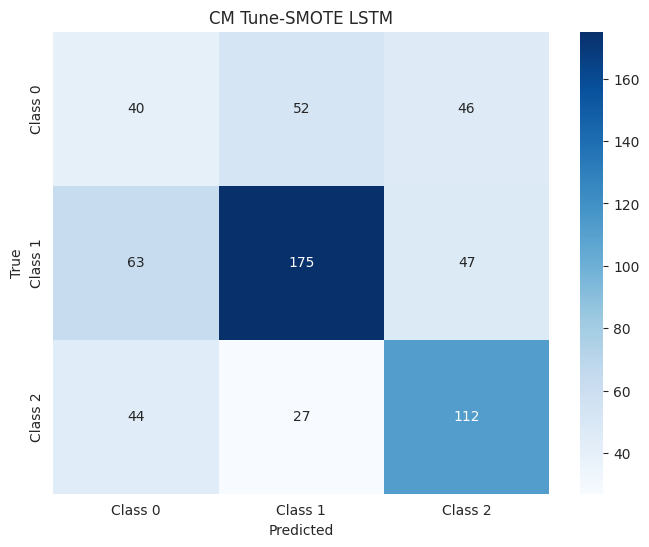

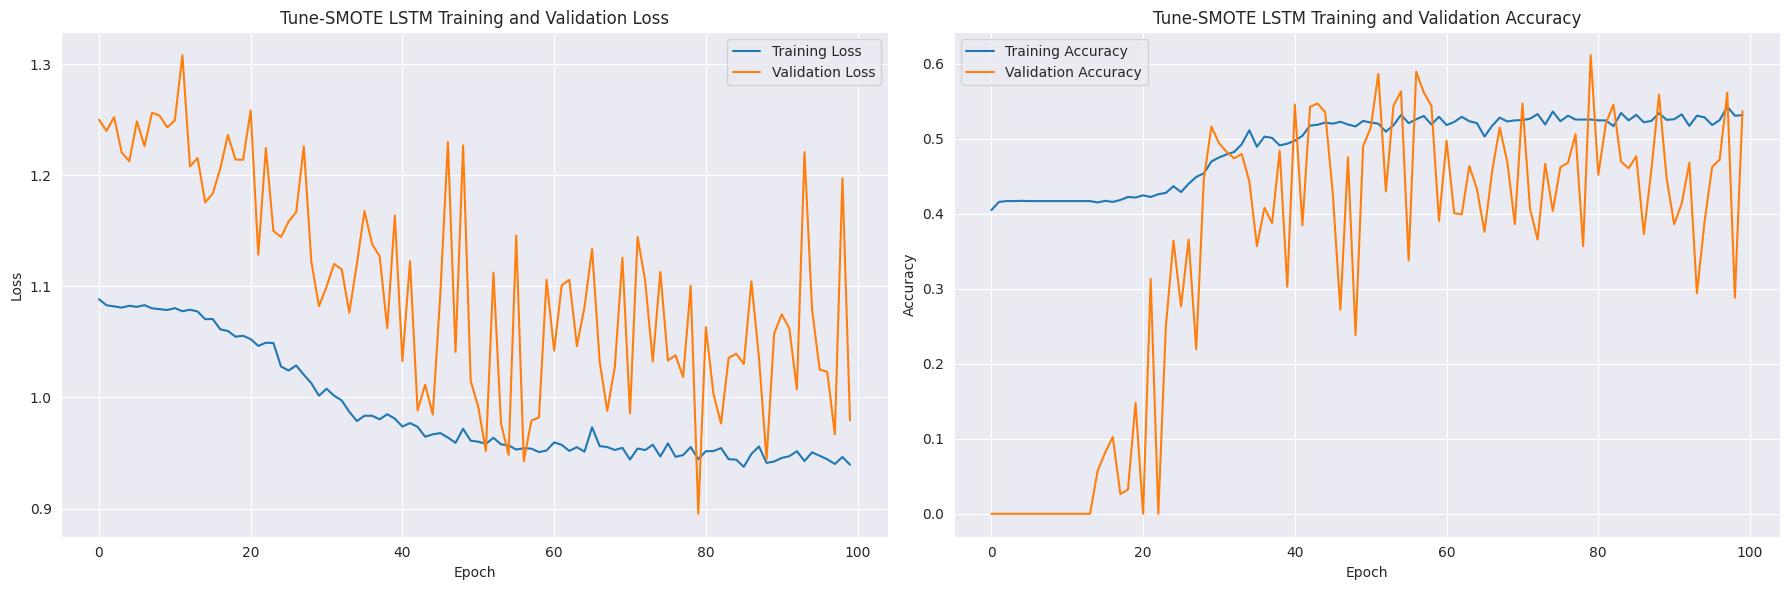

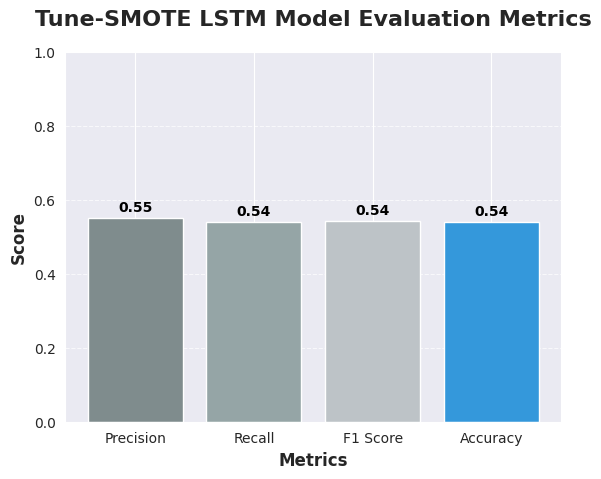

In [80]:
# Evaluate the performance of the base lstm classifier
eval_model(model=model, model_name='Tune-SMOTE LSTM',  X_test=X_test_min_max_encoded, 
           y_test=y_test_encoded, history=history)

There is some improvement with the application of smote. However, there also apprears to be a lot of oscillation in accuracy which indicates that the model is overshooting as it adjusts weights. To address this, let's reduce the learning rate.


### Testing SGD Model with SMOTE Balanced Dataset

In [81]:
# Create an instance of the SMOTE class
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [82]:
# flatten y_train  as SGD expects  1-d data

flattened_y_train_resampled = y_train_resampled.flatten()

In [83]:
# scale the features using minmax scaler
scaler = StandardScaler()

# Fit and transform the training set to standardize its features
X_train_resampled_encoded = scaler.fit_transform(X_train_resampled)

# Transform the testing set using the same scaler to maintain consistency
X_test_encoded = scaler.transform(X_test)

In [84]:
# Suppress SciPy warning
warnings.filterwarnings("ignore", message="A NumPy version >=1.16.5 and <1.23.0 is required")

# Suppress Sklearn warning
warnings.filterwarnings("ignore", category=FutureWarning)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'max_iter': [1000, 30000, 5000],
    'tol': [1e-4, 1e-5, 1e-6],
}

# Initialize SGD classifier
sgd_clf = SGDClassifier(random_state=0)

# Create GridSearchCV object
grid_search = GridSearchCV(sgd_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_resampled_encoded, flattened_y_train_resampled)


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic

GridSearchCV(cv=5, estimator=SGDClassifier(random_state=0), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'loss': ['hinge', 'log_loss', 'modified_huber',
                                  'squared_hinge'],
                         'max_iter': [1000, 30000, 5000],
                         'penalty': ['l2', 'l1', 'elasticnet'],
                         'tol': [0.0001, 1e-05, 1e-06]},
             scoring='accuracy')

Best Parameters: {'alpha': 0.01, 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'elasticnet', 'tol': 0.0001}


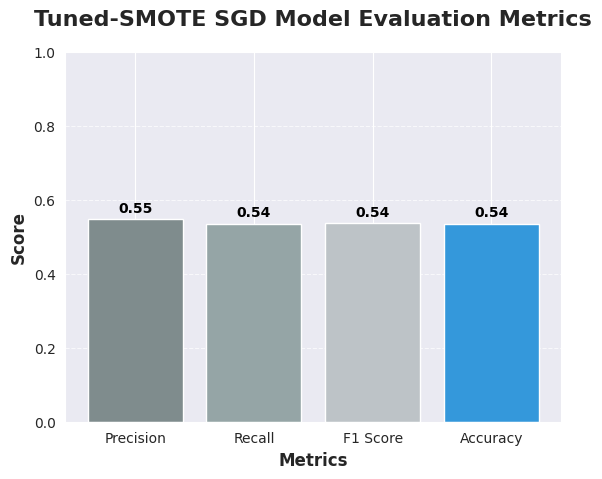

In [85]:
eval_model(model=sgd_clf, model_name='Tuned-SMOTE SGD',  X_test=X_test_encoded, 
           y_test=y_test_encoded, sgd=True, grid_search=grid_search)

### Saving the best SGD Model

In [86]:
# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Save the model to a file
joblib.dump(best_model, '/kaggle/working/models/sgd_smote_model.pkl')


['/kaggle/working/models/sgd_smote_model.pkl']